# ML Competition CAP 5610

# Name: Vinayak Bhosale

# Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn import *
import glob

# Downloading and installing the seglearn and tsflex

In [3]:
!pip install /kaggle/input/whlpackages/seglearn-1.2.5-py3-none-any.whl
!pip install /kaggle/input/whlpackages/tsflex-0.3.0-py3-none-any.whl

Processing /kaggle/input/whlpackages/seglearn-1.2.5-py3-none-any.whl
Processing /kaggle/input/whlpackages/tsflex-0.3.0-py3-none-any.whl


In [4]:
primary_loc = "/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/"

# Importing the CSV Files

In [5]:
train = glob.glob(primary_loc+'train/**/**')

test = glob.glob(primary_loc+'test/**/**')

subjects = pd.read_csv(primary_loc+'subjects.csv')

tasks = pd.read_csv(primary_loc+'tasks.csv')

sub = pd.read_csv(primary_loc+'sample_submission.csv')

# Creating the data frames

In [6]:
tdcsfog_metadata = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')

defog_metadata = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv')

tdcsfog_metadata['Module'] = 'tdcsfog'

defog_metadata['Module'] = 'defog'

metadata=pd.concat([tdcsfog_metadata,defog_metadata])

In [7]:
tasks['Duration'] = tasks['End'] - tasks['Begin']
tasks = pd.pivot_table(tasks, values=['Duration'], index=['Id'], columns=['Task'], aggfunc='sum', fill_value=0)
tasks.columns = [c[-1] for c in tasks.columns]
tasks = tasks.reset_index()
tasks['t_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(tasks[tasks.columns[1:]])


subjects = subjects.fillna(0).groupby('Subject').median()
subjects = subjects.reset_index()
subjects['s_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(subjects[subjects.columns[1:]])
subjects=subjects.rename(columns={'Visit':'s_Visit','Age':'s_Age','YearsSinceDx':'s_YearsSinceDx','UPDRSIII_On':'s_UPDRSIII_On','UPDRSIII_Off':'s_UPDRSIII_Off','NFOGQ':'s_NFOGQ'})

In [8]:
complex_featlist = ['Visit','Test','Medication','s_Visit',
                    's_Age','s_YearsSinceDx','s_UPDRSIII_On',
                    's_UPDRSIII_Off','s_NFOGQ','s_kmeans']

metadata_complex=metadata.merge(subjects,how='left',on='Subject').copy()
metadata_complex['Medication'] = metadata_complex['Medication'].factorize()[0]

In [9]:
from seglearn.feature_functions import base_features, emg_features
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper

In [10]:
basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)

In [11]:
emg_feats = emg_features()
del emg_feats['simple square integral'] # is same as abs_energy (which is in base_features)

emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)

fc = FeatureCollection([basic_feats, emg_feats])

In [12]:
print(fc)

AccAP: (
	win: 5000  : [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__minimum, ['minimum'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__maximum, ['maximum'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__skew, ['skew'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__kurt, ['kurt'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([s

In [13]:
import pathlib

def reader(f):
    
    try:
        df = pd.read_csv(f, index_col="Time", usecols=['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn' , 'Walking'])
        
        df['Id'] = f.split('/')[-1].split('.')[0]
        df['Module'] = pathlib.Path(f).parts[-2]
        
        df['Time_frac']=(df.index/df.index.max()).values
        
        df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
        
        df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
        df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin").astype(np.float32)
        df = df.merge(df_feats, how="left", left_index=True, right_index=True)
        df.fillna(method="ffill", inplace=True)
        return df
    
    except:
        pass
    
    
train = pd.concat([reader(f) for f in tqdm(train)]).fillna(0); print(train.shape)
cols = [c for c in train.columns if c not in ['Id','Subject','Module', 'Time', 'StartHesitation', 'Turn' , 'Walking', 'Valid', 'Task','Event']]
pcols = ['StartHesitation', 'Turn' , 'Walking']
scols = ['Id', 'StartHesitation', 'Turn' , 'Walking']

  0%|          | 0/970 [00:00<?, ?it/s]

(20588374, 72)


# resetting the index values of the train data set

In [14]:
train = train.reset_index(drop=True)

In [15]:
train

,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Id,Module,Time_frac,t_kmeans,...,AccV__minimum__w=5000,AccV__mse__w=5000,AccV__root_mean_square__w=5000,AccV__skew__w=5000,AccV__slope_sign_changes__w=5000,AccV__std__w=5000,AccV__var__w=5000,AccV__waveform_length__w=5000,AccV__willison_amplitude__w=5000,AccV__zero_crossing__w=5000
0,-1.002697,0.022371,0.068304,0,0,0,be9d33541d,defog,0.000000,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.109620,0.012017,75.765259,4999.0,4999.0
1,-1.002641,0.019173,0.066162,0,0,0,be9d33541d,defog,0.000008,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.109620,0.012017,75.765259,4999.0,4999.0
2,-0.999820,0.019142,0.067536,0,0,0,be9d33541d,defog,0.000017,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.109620,0.012017,75.765259,4999.0,4999.0
3,-0.998023,0.018378,0.068409,0,0,0,be9d33541d,defog,0.000025,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.109620,0.012017,75.765259,4999.0,4999.0
4,-0.998359,0.016726,0.066448,0,0,0,be9d33541d,defog,0.000034,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.109620,0.012017,75.765259,4999.0,4999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20588369,-9.915920,-0.105897,-1.123455,0,0,0,0506d9a39f,tdcsfog,0.999224,-1.0,...,-12.006635,15128.738281,9.785270,-0.796066,63.0,0.648977,0.421171,43.582512,157.0,157.0
20588370,-9.693752,-0.066892,-1.114903,0,0,0,0506d9a39f,tdcsfog,0.999418,-1.0,...,-12.006635,15128.738281,9.785270,-0.796066,63.0,0.648977,0.421171,43.582512,157.0,157.0
20588371,-9.548118,-0.098315,-1.112123,0,0,0,0506d9a39f,tdcsfog,0.999612,-1.0,...,-12.006635,15128.738281,9.785270,-0.796066,63.0,0.648977,0.421171,43.582512,157.0,157.0
20588372,-9.469803,-0.111004,-1.130814,0,0,0,0506d9a39f,tdcsfog,0.999806,-1.0,...,-12.006635,15128.738281,9.785270,-0.796066,63.0,0.648977,0.421171,43.582512,157.0,157.0


# Visualizing the data

<AxesSubplot:>

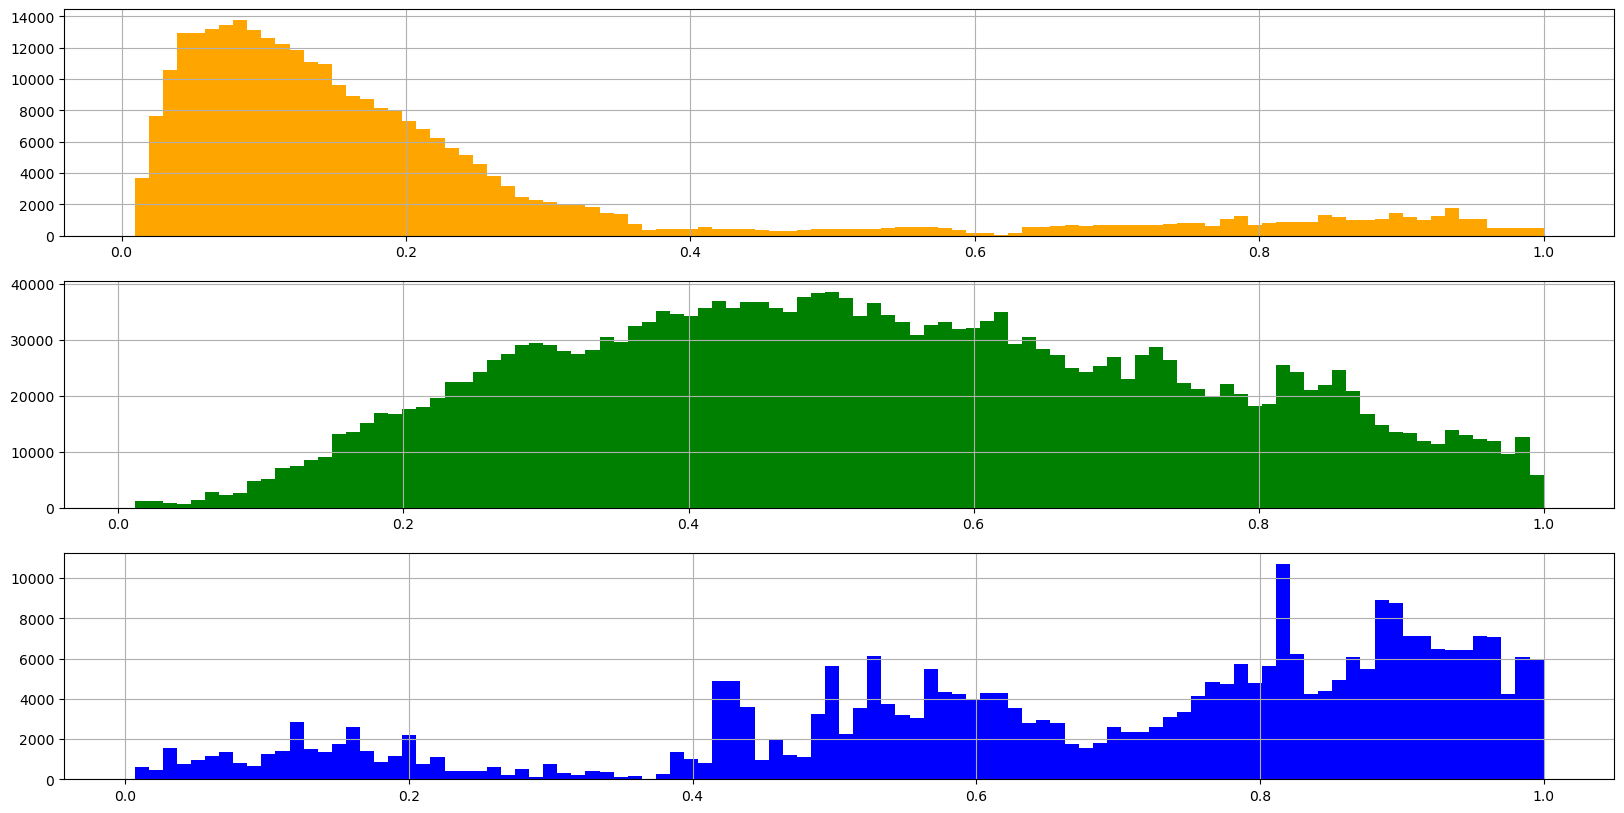

In [31]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(3,1,figsize=(20,10))
train.loc[train['StartHesitation']==1,'Time_frac'].hist(ax=ax[0],bins=100,color = "orange")
train.loc[train['Turn']==1,'Time_frac'].hist(ax=ax[1],bins=100,color = "green")
train.loc[train['Walking']==1,'Time_frac'].hist(ax=ax[2],bins=100,color = "blue")

# Modeling

In [17]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.metrics import average_precision_score, make_scorer

best_params_ = {
                 'estimator__colsample_bytree': 0.5282057895135501, 
                 'estimator__learning_rate': 0.22659963168004743, 
                 'estimator__max_depth': 8, 
                 'estimator__min_child_weight': 3.1233911067827616, 
                 'estimator__n_estimators': 291, 
                 'estimator__subsample': 0.9961057796456088
                }

best_params_ = {kk: v for k, v in best_params_.items() for kk in k.split('__')} 
del best_params_['estimator']
print(best_params_)

{'colsample_bytree': 0.5282057895135501, 'learning_rate': 0.22659963168004743, 'max_depth': 8, 'min_child_weight': 3.1233911067827616, 'n_estimators': 291, 'subsample': 0.9961057796456088}


In [18]:
from sklearn.base import clone

def custom_average_precision(y_true, y_pred):
    score = average_precision_score(y_true, y_pred)
    return 'average_precision', score, True

class LGBMMultiOutputRegressor(MultiOutputRegressor):
    def fit(self, X, y, eval_set=None, **fit_params):
        self.estimators_ = [clone(self.estimator) for _ in range(y.shape[1])]
        
        for i, estimator in enumerate(self.estimators_):
            if eval_set:
                fit_params['eval_set'] = [(eval_set[0], eval_set[1][:, i])]
            estimator.fit(X, y[:, i], **fit_params, verbose=False)
        
        return self

# Training the model

In [19]:
from sklearn.model_selection import GroupKFold

N_FOLDS=5
kfold = GroupKFold(N_FOLDS)
group_var = train.Subject
groups=kfold.split(train, groups=group_var)
regs=[]
cvs=[]
for fold, (tr_idx,te_idx ) in enumerate(tqdm(groups, total=N_FOLDS, desc="Folds")):
    tr_idx=pd.Series(tr_idx).sample(n=2000000,random_state=42).values
    base_regressor = lgb.LGBMRegressor(**best_params_)
    multioutput_regressor = LGBMMultiOutputRegressor(base_regressor)
    x_tr,y_tr=train.loc[tr_idx,cols].to_numpy(),train.loc[tr_idx,pcols].to_numpy()
    x_te,y_te=train.loc[te_idx,cols].to_numpy(),train.loc[te_idx,pcols].to_numpy()

    multioutput_regressor.fit(
    x_tr,y_tr,
    eval_set=(x_te,y_te),
    eval_metric=custom_average_precision,
    early_stopping_rounds=25
    )
    regs.append(multioutput_regressor)
    cv=metrics.accuracy_score(y_te, multioutput_regressor.predict(x_te).clip(0.0,1.0)>5)
    cvs.append(cv)
    
    
print(cvs)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecat

[0.6798107125505366, 0.8678066672052954, 0.932935836044777, 0.8793966953622305, 0.9477153696624164]


In [20]:
accuracies = max(cvs)
print(f"the accuracy of the model is: {accuracies}")

the accuracy of the model is: 0.9477153696624164


# Making the predictions

In [22]:
sub['t'] = 0
submission = []
for f in test:
    df = pd.read_csv(f)
    df.set_index('Time', drop=True, inplace=True)

    df['Id'] = f.split('/')[-1].split('.')[0]
    df['Time_frac']=(df.index/df.index.max()).values
    df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
    df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
    df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin")
    df = df.merge(df_feats, how="left", left_index=True, right_index=True)
    df.fillna(method="ffill", inplace=True)
   
    res_vals=[]
    for i_fold in range(N_FOLDS):
        res_val=np.round(regs[i_fold].predict(df[cols]).clip(0.0,1.0),3)
        res_vals.append(np.expand_dims(res_val,axis=2))
    res_vals=np.mean(np.concatenate(res_vals,axis=2),axis=2)
    res = pd.DataFrame(res_vals, columns=pcols)
    
    df = pd.concat([df,res], axis=1)
    df['Id'] = df['Id'].astype(str) + '_' + df.index.astype(str)
    submission.append(df[scols])
submission = pd.concat(submission)
submission = pd.merge(sub[['Id']], submission, how='left', on='Id').fillna(0.0)
submission[scols].to_csv('submission.csv', index=False)

# Prediction values

In [23]:
submission

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0.0124,0.0132,0.0130
1,003f117e14_1,0.0124,0.0132,0.0130
2,003f117e14_2,0.0124,0.0132,0.0130
3,003f117e14_3,0.0124,0.0132,0.0130
4,003f117e14_4,0.0124,0.0132,0.0130
...,...,...,...,...
286365,02ab235146_281683,0.0112,0.0334,0.0126
286366,02ab235146_281684,0.0112,0.0334,0.0126
286367,02ab235146_281685,0.0112,0.0334,0.0126
286368,02ab235146_281686,0.0112,0.0334,0.0126
